#### comparison between other biomarkers

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [2]:
# model 1: 1-year conversion
merged = pd.read_pickle('../dataset/merged_data_shuffled_2class.pkl')
selected = merged[['SDK1','MAPKAPK2','BUD13','ATP8A2','AIFM3','ZNF625','IFNW1','CASP10','AP001318.2','ABCD1','TMEM240','NOTCH4']]

In [3]:
labels = np.array(merged['end'])
features = np.array(selected)
print(labels.shape)
print(features.shape)

X = features
Y = labels
print(Y)

(107,)
(107, 12)
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


(mean) ACC:  0.8597402597402597 Precision:  0.2 Recall:  0.06666666666666667 F1:  0.1 AUC:  0.8992072862202732
(std) ACC:  0.041756382863333295 Precision:  0.4 Recall:  0.13333333333333333 F1:  0.2 AUC:  0.03498794905707339


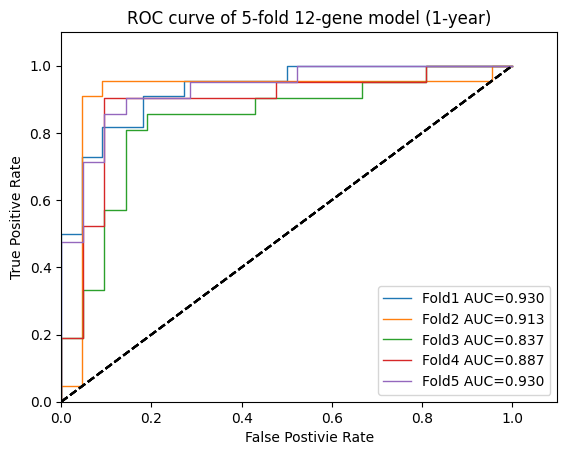

In [4]:
import xgboost as xgb
from sklearn.utils import class_weight

classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=Y
)

# 5-fold
model_name = 'XGBoost'
cv_result = []
cv_label = []
cv = KFold(n_splits=5)
for train_index, valid_index in cv.split(X):
    train_x,test_x = X[train_index], X[valid_index]
    train_y,test_y = Y[train_index], Y[valid_index]
    #clf = xgb.XGBClassifier(n_jobs=-1,n_estimators=15,max_depth=6)
    clf = xgb.XGBClassifier(n_jobs=-1)
    clf.fit(train_x, train_y)
    result = clf.predict_proba(test_x)
    cv_result.append(result)
    cv_label.append(test_y)
#print(cv_result)
#print(cv_label)

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5): # 5-fold evaluation
    y_score = cv_result[i].argmax(axis=1)                                   
    y_score_pro = cv_result[i] # (.., 2)
    y_one_hot = to_categorical(cv_label[i])
    y_score_one_hot = to_categorical(y_score)

    acc_list.append(accuracy_score(cv_label[i], y_score))
    precision_list.append(precision_score(cv_label[i], y_score))
    recall_list.append(recall_score(cv_label[i], y_score))
    f1_list.append(f1_score(cv_label[i], y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold 12-gene model (1-year)')
plt.savefig('../images/class2/roc-5fold-12gene-1year.png',dpi=300)
plt.show()

In [5]:
merged = pd.read_pickle('../dataset/merged_data_shuffled_3class.pkl')
selected = merged[['SDK1','MAPKAPK2','BUD13','ATP8A2','AIFM3','ZNF625','IFNW1','CASP10','AP001318.2','ABCD1','TMEM240','NOTCH4']]
labels = np.array(merged['end'])
features = np.array(selected)
print(labels.shape)
print(features.shape)

X = features
Y = labels
print(Y)

train_y = np.array(merged['end'][0:int(0.9*merged.shape[0])])
train_x = np.array(selected[0:int(0.9*selected.shape[0])])
test_y = np.array(merged['end'][int(0.9*merged.shape[0]):])
test_x = np.array(selected[int(0.9*selected.shape[0]):])

(107,)
(107, 12)
[0 1 1 0 0 0 0 0 2 0 1 1 0 1 0 1 2 2 0 2 1 0 1 0 0 2 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 1 0 1 1 1 1 2 1 0 0 0 0 1 0 1 0 2 1 0 0 0 1 1 0 0 0 1 0 0 0 2 0 0 1
 0 0 1 0 0 0 0 2 0 0 1 1 1 2 0 1 1 1 1 0 0 1 1 1 0 0 1 0 0 0 0 2 1]


              precision    recall  f1-score   support

          re       0.50      0.83      0.62         6
         sym       0.00      0.00      0.00         4
         con       0.00      0.00      0.00         1

    accuracy                           0.45        11
   macro avg       0.17      0.28      0.21        11
weighted avg       0.27      0.45      0.34        11



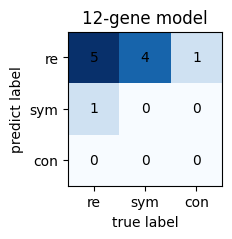

In [6]:
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.utils import class_weight

model_name = 'XGBoost'

clf = xgb.XGBClassifier(n_jobs=-1)
#clf.fit(train_x, train_y, sample_weight=class_weight.compute_sample_weight("balanced", train_y))
clf.fit(train_x, train_y)
result = clf.predict_proba(test_x)
#print(result)
y_pred = np.argmax(result,axis=1)

t = classification_report(test_y, y_pred, target_names=['re', 'sym', 'con'])
print(t)
confusion = confusion_matrix(test_y, y_pred)
ax = plt.figure(figsize=(2, 2))
#ax = sns.heatmap(confusion, fmt='.2f', cmap='Blues', annot=True)
ax = plt.imshow(confusion.T, cmap='Blues')
indices = range(len(confusion))
classes = ['re', 'sym', 'con']
#ax.set_yticklabels(labels=ax.get_yticklabels(), va='center')
plt.xticks(indices, classes)
plt.yticks(indices, classes)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('12-gene model')

for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index],ha='center',va='center')
        #plt.text(first_index, second_index, np.round(float(confusion[first_index][second_index])/np.sum(confusion[first_index]),2),ha='center')
plt.savefig('../images/class3/12-gene model',dpi=300, bbox_inches = 'tight')
plt.show()

In [7]:
# model 2: 2-year conversion
merged = pd.read_pickle('../dataset/2year_merged_data_shuffled_2class.pkl')
selected = merged[['SYP','IFNW1','CNTNAP3']]

labels = np.array(merged['end'])
features = np.array(selected)
print(labels.shape)
print(features.shape)

X = features
Y = labels
print(Y)

(51,)
(51, 3)
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 0 1]


(mean) ACC:  0.8218181818181819 Precision:  0.06666666666666667 Recall:  0.2 F1:  0.1 AUC:  0.8891239669421488
(std) ACC:  0.07683835130587434 Precision:  0.13333333333333333 Recall:  0.4 F1:  0.2 AUC:  0.06612856486455528


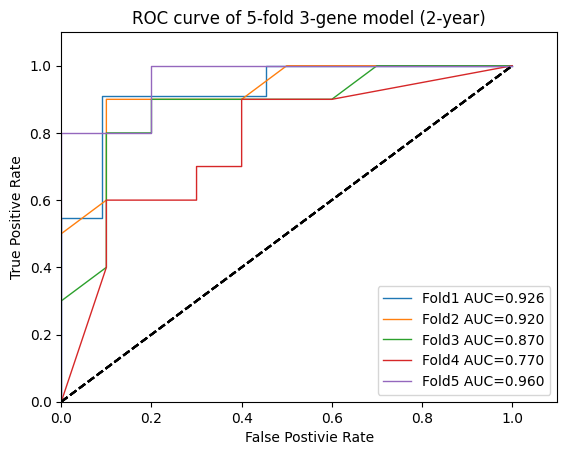

In [8]:
import xgboost as xgb
from sklearn.utils import class_weight

classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=Y
)

# 5-fold
model_name = 'XGBoost'
cv_result = []
cv_label = []
cv = KFold(n_splits=5)
for train_index, valid_index in cv.split(X):
    train_x,test_x = X[train_index], X[valid_index]
    train_y,test_y = Y[train_index], Y[valid_index]
    #clf = xgb.XGBClassifier(n_jobs=-1,n_estimators=15,max_depth=6)
    clf = xgb.XGBClassifier(n_jobs=-1)
    clf.fit(train_x, train_y)
    result = clf.predict_proba(test_x)
    cv_result.append(result)
    cv_label.append(test_y)
#print(cv_result)
#print(cv_label)

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5): # 5-fold evaluation
    y_score = cv_result[i].argmax(axis=1)                                   
    y_score_pro = cv_result[i] # (.., 2)
    y_one_hot = to_categorical(cv_label[i])
    y_score_one_hot = to_categorical(y_score)

    acc_list.append(accuracy_score(cv_label[i], y_score))
    precision_list.append(precision_score(cv_label[i], y_score))
    recall_list.append(recall_score(cv_label[i], y_score))
    f1_list.append(f1_score(cv_label[i], y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold 3-gene model (2-year)')
plt.savefig('../images/class2/roc-5fold-3gene-model.png',dpi=300)
plt.show()